In [1747]:
import math
from scipy import stats
from scipy import optimize 
from statistics import mean
import numpy as np
import pandas as pd
import matplotlib as mp
import matplotlib.pyplot as plt
from scipy.optimize import bisect
np.random.seed(30)

In [1755]:
Nsims = 5000 # Number of simulations
# Time grid
T = 6.5  # 1 day or 6.5 hours
lam = 27 # Frequency of Arrival of Order-Flow Changes (in hours)
Ndt = int(lam*6.5)  # Number of time increments 
dt = T/Ndt  # Time change increment 
t = np.arange(0, T+0.00000001, dt)  # Time increments vector 
kappa = 8 # Rate of Order-Flow Mean-reversion
eta_mean = 2#1.65  # Mean Order-Flow Jump Size
initial_price = 100  # Starting Fundamental Price
initial_invt = 15 # Starting Inventory amount
sigma = 0.31  # Volatilty 
k =  7.2e-2  
b = 1.88e-2 
phi = 10*k# Running penalty coefficient

In [1756]:
gamma = (phi/k)**0.5
tau = T-t  # Time remaining to the end of the trading horizon
chi = gamma*np.cosh(gamma*tau)/np.sinh(gamma*tau)
# Computing ell variable
def exp_p(a, tau):
    return (1 - np.exp(-a*tau)) / a
v1 = np.exp(gamma * tau)
tot = kappa + gamma
dif = kappa - gamma
ell = 0.5*( v1 * exp_p(tot, tau) - v1**-1 * exp_p(dif, tau))/(np.sinh(gamma*tau))

C:\Users\Roberto\AppData\Local\Temp/ipykernel_8756/523042087.py:3: RuntimeWarning: divide by zero encountered in true_divide
  chi = gamma*np.cosh(gamma*tau)/np.sinh(gamma*tau)
C:\Users\Roberto\AppData\Local\Temp/ipykernel_8756/523042087.py:10: RuntimeWarning: invalid value encountered in true_divide
  ell = 0.5*( v1 * exp_p(tot, tau) - v1**-1 * exp_p(dif, tau))/(np.sinh(gamma*tau))


In [1757]:
# Allocate space for the processes we simulate and store
mu = np.full([Nsims, Ndt+1], np.nan)  # Order Flow matrix
# Initializing variables for simulation base on computed strategy
X = np.full([Nsims, Ndt+1], np.nan)  # Cost matrix of Strategy
Q = np.full([Nsims, Ndt+1], np.nan)  # Inventory matrix
S = np.full([Nsims, Ndt+1], np.nan)  # Execution Price matrix
nu = np.full([Nsims, Ndt+1], np.nan)  # Rate of Trading matrix
# Initializing variables for simulation of Almgren-Chriss strategy
X_AC = np.full([Nsims, Ndt+1], np.nan)  # Cost matrix of Strategy
Q_AC = np.full([Ndt+1], np.nan)  # Inventory matrix
S_AC = np.full([Nsims, Ndt+1], np.nan)  # Execution Price matrix
nu_AC = np.full([Ndt+1], np.nan)  # rate of trading matrix

In [1758]:
# Initial  conditions
Q[:, 0] = initial_invt
mu[:, 0] = 0
S[:, 0] = initial_price  
X[:, 0] = 0 
Q_AC[0] = initial_invt 
S_AC[:, 0] = initial_price
X_AC[:, 0] = 0

In [1759]:
#  Simulating computed strategy
for i in range(Ndt):

    # Compute optimal trading rate
    nu[:, i] = chi[i]*Q[:, i] - 0.5 * b / k * ell[i] * mu[:, i]
    nu_AC[i] = chi[i] * Q_AC[i]

    # Account for the cost of the trades above and update inventory
    X[:, i + 1] = X[:, i] + (S[:, i] - k * nu[:, i]) * nu[:, i] * dt
    Q[:, i+1] = Q[:, i] - nu[:, i] * dt
    
    # If you were trading using Almgren-Chriss this is what you would do
    X_AC[:, i + 1] = X_AC[:, i] + (S_AC[:, i] - k * nu_AC[i]) * nu_AC[i] * dt
    Q_AC[i+1] = Q_AC[i] - nu_AC[i] * dt

    # simulate the SDE for price forward 
    dW = dt**0.5 * np.random.randn(Nsims, 1)
    
    S[:, i + 1] = S[:, i] + b * (mu[:, i] - nu[:, i]) * dt + (sigma * dW).reshape(Nsims)
    S_AC[:, i + 1] = S_AC[:, i] + b * (mu[:, i] - nu_AC[i]) * dt + (sigma * dW).reshape(Nsims)
    
    #  simulate order-flow forward
    
    # decide if an order-flow update arrives
    #dn = (np.random.rand(Nsims, 1) < 1 - np.exp(-2 * lam * dt)).astype(int)
    dn = np.random.poisson(lam*dt,(Nsims, 1))
    dn = np.random.poisson(lam,(Nsims, 1))
    # decide if it adds to the buy/sell pressure
    buysell = (np.random.rand(Nsims, 1) < 0.5)
    # generate the size of the order-flow impact
    eta = np.random.exponential(eta_mean,(Nsims, 1))
    
    # simulate the SDE for mu forward
    mu[:, i + 1] = mu[:, i]*np.exp(-kappa * dt) + (eta * dn * (2 * buysell - 1)).reshape(Nsims)

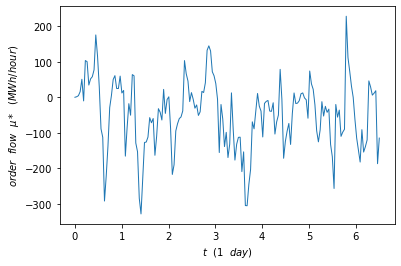

In [1761]:
plt.plot(t,mu[1], linewidth=1, )
plt.xlabel("$t \ \ (1\ \ day)$")
plt.ylabel("$order \ \ flow \ \ \u03BC* \ \ (MWh/hour) $")
plt.show()

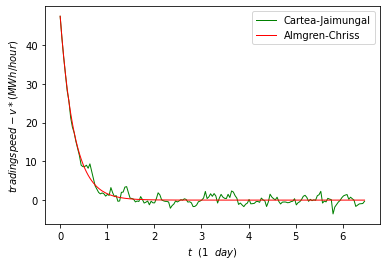

In [1762]:
plt.plot(t,nu[1], color = 'g', linewidth=1, label = 'Cartea-Jaimungal')
plt.plot(t,nu_AC, color = 'r', linewidth=1, label = 'Almgren-Chriss')
plt.legend()
plt.xlabel("$t \ \ (1\ \ day)$")
plt.ylabel("$trading speed -v* (MWh/hour) $")
plt.show()

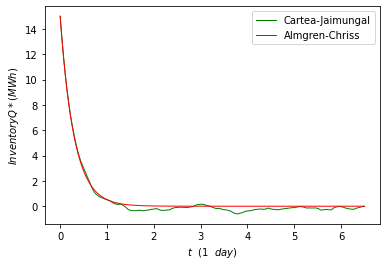

In [1763]:
plt.plot(t,Q[1], color = 'g', linewidth=1, label = 'Cartea-Jaimungal')
plt.plot(t,Q_AC, color = 'r', linewidth=1, label = 'Almgren-Chriss')
plt.legend()
plt.xlabel("$t \ \ (1 \ \ day)$")
plt.ylabel("$Inventory Q* (MWh)$")
plt.show()

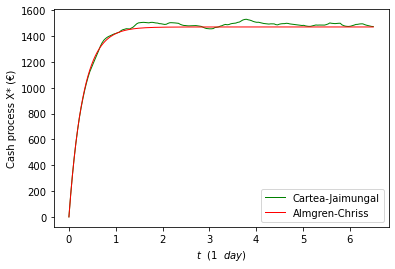

In [1764]:
plt.plot(t,X[1], color = 'g', linewidth=1, label = 'Cartea-Jaimungal')
plt.plot(t,X_AC[1], color = 'r', linewidth=1, label = 'Almgren-Chriss')
plt.legend()
plt.xlabel("$t \ \ (1 \ \ day)$")
plt.ylabel(r'Cash process X* (€)')
plt.show()

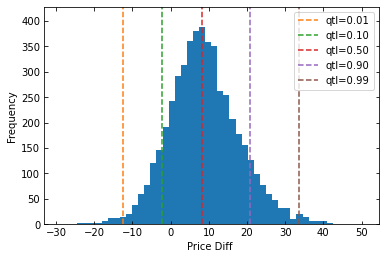

In [1765]:
# Visualizing price difference between strategies 
fig_7 = plt.figure()
plt.tick_params(direction='in', bottom=True, top=True, left=True, right=True)
BasisPointSavings = ( X[:,-1]-X_AC[:, -1] ) / X_AC[:, -1] * 10**4

rets = plt.hist(BasisPointSavings, bins=50)

prob = [0.01, 0.1, 0.5, 0.9, 0.99]
q = np.quantile(BasisPointSavings, prob)
maxHeight = 1.1*np.max(rets[0])
for i in range(len(q)):
    plt.plot(q[i]*np.array([1,1]), np.array([0,maxHeight]), '--', label= prob[i])
plt.ylim((0,maxHeight))  
plt.ylabel('Frequency')
plt.xlabel('Price Diff ')
plt.legend(('qtl=0.01','qtl=0.10','qtl=0.50','qtl=0.90','qtl=0.99'))
plt.show()